# An Exploration as to the Success of Investigating the Primary Motor Cortex Model & its Parameters

### Chenghan Zhou (cz4gr) and Jalon Daniels (jmd3ae)


## Abstract/Background
- During daily life, we make many reaching movements. 
- The first reaching movements, emerge around 3 to 4 months of age.
- During the following months, the reaching movements rapidly become more regular and smooth. 
- Thereafter, the fine-tuning of reaching takes many years. 

## The Anatomy of it...
<img src="./images/Anatomy.png">

- The motor cortex is the region of the cerebral cortex. 
    - Its neurons are responsible for the planning, control, and execution of voluntary movements. 
    - As movements are fine-tuned, reaching movements in healthy adults can be characterized by a bell-shaped velocity profile that consists of an acceleration and a deceleration. 
- As time goes on, the reaching movements become faster, straighter, and smoother.
- The increase in smoothness of the reaching movements is due to a decrease of the corrections of the movement path. 

## Methodology
- The primary research goal was to identify the difference between premotor cortex and primary motor cortex when an animal performs repetitive behavior. 
- Our dataset contained information about velocity, acceleration, position of the monkey's hand for all the trials. 
    - Dataset also provides the number of spikes in each time bin during the reaching task. 

## Original Paper: Linear-Nonlinear-Time-Warp-Poisson models of neural activity
- Prominent models of spike trains assume only one source of variability – stochastic (Poisson) spiking, when stimuli and behavior are fixed.
- However, spike trains may also reflect variability due to internal processes such as planning
- Combine the standard Linear-Nonlinear-Poisson (LNP) model with Dynamic Time Warping (DTW) to account for shared temporal variability
- Considerably improves predictions of neural activity

## Dataset: pmd-1 (Motor Planning)
| File Name     | Monkey  | # Trials  | # Reaches | # Neurons, M1 | # Neurons, PMd |
| ------------- | ------- | --------- | --------- | ------------- | -------------- |
| MM_S1         | MM      | 140       | 496       | 67            | 94             |
| MT_S1         | MT      | 116       | 419       | 0             | 49             |
| MT_S2         | MT      | 178       | 646       | 0             | 49             |
| MT_S3         | MT      | 174       | 625       | 0             | 57             |

### Data Preparation

- Since we are interested in comparison between M1 and PMd data, we will only use data MM_S1.

- Packages used are numpy (for organization of arrays), pyglmnet (generalized linear model regression), matplotlib.pyplot (graph the results). We already finish reading data in "/src/io.py" and the documents are in readme.md in "/data" folder. 

- During the most of the analysis, we are interested in M1 and PMd neural data, kinematics (especially velocity and position), starting and ending time of reaches

In [1]:
import numpy as np
from pyglmnet import GLM
import matplotlib.pyplot as plt
from src import io

In [2]:
header, version, globals, reaches, trials = io.read_data("MM_S1_processed.mat")

In [3]:
n_reaches = len(reaches)

b0_M1 = []
b1_M1 = []
b2_M1 = []

b0_PMd = []
b1_PMd = []
b2_PMd = []

## Linear-Nonlinear-Poisson Cascade Model Regression

As we have learnt in class, spikes of neurons can be modeled as a Linear-Nonlinear Poisson Model. The following equations gives a mathematical model how to generate spikes from a poisson model. In the model, $X$ refers to feature vector. We use velocity and position seperately. The parameter for the Poisson distribution, $\lambda$, is calculated by an exponential equation of a linear function on $X$, where the coefficient of this linear function is what we are trying to calculate. After getting $\lambda$, we are able to get the conditional probability of getting $n_{spikes}$ in the Poisson distribution.

\begin{equation}
    \sum_{k=1}^K \theta_k x^{(k)} = X \Theta \\
    \lambda|X, \Theta = \exp(X \Theta) \\
    n_{spikes}|\lambda \sim Poisson(\lambda) \\
    \text{Likelihood} = \prod_{t=1}^T Poisson(n_t|\lambda_t) = \prod_{t=1}^T \frac{\lambda_t^{n_t}exp(-\lambda_t)}{n_t!} \\
    \text{log Likelihood} = \sum_{t=1}^T(n_t \log{\lambda_t} - \lambda_t - \log{n_t!}) \\
\end{equation}

Our goal of the Regression is to find $\Theta$ to maximize log Likelihood. This can be achieved by using a standard method called gradient descent.

## Method used: Gradient Descent

Gradient descent is an optimization algorithm used to minimize some function by iteratively moving in the direction of steepest descent as defined by the negative of the gradient. In the setting of Poisson model, since the induces log Likelihood is convex, we are able to use this standard algorithm to obtain the desired coefficient $\Theta$. In this project, we use the package "pyglmnet" to do General Linear Regression, which allows us to do Poisson regression. Notations will be different from the above Linear-Nonliear-Poisson model.

Objective function:
\begin{equation}
    \min_{\beta_0, \beta}{\frac{1}{N}\sum_{t=1}^N}\mathcal{L}(y_i, \beta_0 + \beta^T x_i) + \lambda[\frac{1}{2}(1-\alpha) ||\beta||^2_2 + \alpha ||\beta||_1]
\end{equation}
- The first term refers to the negative log likelihood that we want to minimize. The second and third term are regulation terms to make sure the log likelihood is not arbitrarily large by setting large coefficients.
- In our project, we set $\lambda$ to be $0.05$ and $\alpha$ to be $0.01$, referencing to the original paper *Linear-nonlinear-time-warp-poisson models of neural activity*

Log-likelihood function:
\begin{aligned}
        \mathcal{L} = \sum_i y_i \log{\mu_i} - \sum_i \mu
\end{aligned}
- The term $\log n_t!$ in the previous cell is not important since we are focusing on the coefficient, where $\log n_t!$ is a constant.
- Here, $y_i$ is equivalent to the number of spikes $n_spikes$. $\lambda_i$ is equivalent to $\exp(X \Theta)$, which relates to the unknown coefficient $\Theta$.

Mean function:
\begin{aligned}
    & z_i = \beta_0 + \sum_i \beta_j x_{ij} \\
    & \mu_i = \left\{
                    \begin{array}{ll}
                      \exp(z_i), \quad z_i \leq \eta\\
                      \exp(\eta)z_i + (1-\eta)\exp(\eta), \quad z_i > \eta
                    \end{array}
                  \right.
\end{aligned}
- The above model captures the Poisson nature. $\eta$ is a regulation term and set to $2.0$ by default, also folloing the original paper.

Gradient:
\begin{aligned}
    & \frac{\partial J}{\partial \beta_0} = \frac{1}{n} \sum_{i: z_i \leq \eta} (\mu_i - y_i) + \frac{1}{n} \sum_{i:z_i > \eta} \exp(\eta)(1-\frac{y_i}{\mu_i}) \\
    & \frac{\partial J}{\partial \beta_j} = \frac{1}{n} \sum_{i: z_i \leq \eta} (\mu_i - y_i) x_{ij} + \frac{1}{n} \sum_{i:z_i > \eta} \exp(\eta)(1-\frac{y_i}{\mu_i}) x_{ij}
\end{aligned}

## Methodology:
    
- Firstly, we found the first onset of different neurons and determined if this onset time has changed between different trials. 
- We take average of all neurons in PMd and M1 data.
- Then, we did a poisson regression for our model. 
- Finally, we generated graphs of the relationship between coefficients of M1 and PMd. 

The following cell gives the relationship in response to position. The results show that the coefficient for both x position and y position are positively correlated to each other, which means how position correlates to M1 and PMd neurons are mainly the same.

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pyglmnet/pyglmnet.py:864: UserWarning: Reached max number of iterations without convergence.
  "Reached max number of iterations without convergence.")


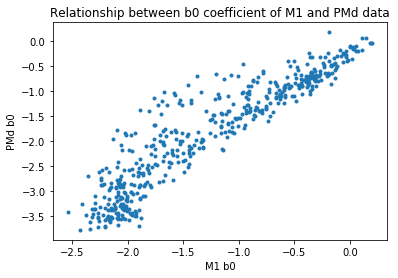

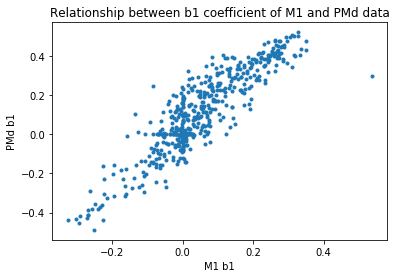

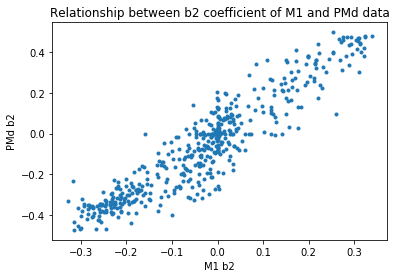

In [4]:
for i in range(n_reaches):
    M1_neural_data = reaches[i]["M1 neural data"]
    PMd_neural_data = reaches[i]["PMd neural data"]
    n_spikes_M1 = np.sum(M1_neural_data, axis=0)/67.0
    n_spikes_PMd = np.sum(PMd_neural_data, axis=0)/94.0
    trial_num = reaches[i]["trial number"]
    timestamps = reaches[i]["timestamps"]
    start_time = reaches[i]["start time"]
    end_time = reaches[i]["end time"]
    kinematics = reaches[i]["kinematics"]
    start_idx = 0
    end_idx = timestamps.size-1
    while timestamps[start_idx+1]<start_time:
        start_idx += 1
    while timestamps[end_idx]>end_time:
        end_idx -= 1
    n_spikes_M1 = n_spikes_M1[start_idx:end_idx]
    n_spikes_PMd = n_spikes_PMd[start_idx:end_idx]
    features = []
    n_features = 2
    for j in range(len(kinematics)):
        features.append([kinematics[j]["position"][0], kinematics[j]["position"][1]])
    features = np.array(features)
    features = features[start_idx:end_idx, : ]
    
    glm_M1 = GLM(distr='poisson', score_metric='pseudo_R2', reg_lambda=0.05, alpha=0.01)
    glm_M1.fit(features, n_spikes_M1)
    b0_M1.append(glm_M1.beta0_)
    b1_M1.append(glm_M1.beta_[0])
    b2_M1.append(glm_M1.beta_[1])
    
    glm_PMd = GLM(distr='poisson', score_metric='pseudo_R2', reg_lambda=0.05, alpha=0.01)
    glm_PMd.fit(features, n_spikes_PMd)
    b0_PMd.append(glm_PMd.beta0_)
    b1_PMd.append(glm_PMd.beta_[0])
    b2_PMd.append(glm_PMd.beta_[1])

plt.figure()
plt.plot(b0_M1, b0_PMd, '.')
plt.xlabel('M1 b0')
plt.ylabel('PMd b0')
plt.title("Relationship between b0 coefficient of M1 and PMd data")
plt.show()

plt.figure()
plt.plot(b1_M1, b1_PMd, '.')
plt.xlabel('M1 b1')
plt.ylabel('PMd b1')
plt.title("Relationship between b1 coefficient of M1 and PMd data")
plt.show()

plt.figure()
plt.plot(b2_M1, b2_PMd, '.')
plt.xlabel('M1 b2')
plt.ylabel('PMd b2')
plt.title("Relationship between b2 coefficient of M1 and PMd data")
plt.show()

The next cell gives the relationship in response to velocity. While coefficients for PMd changes in a large range, both for x velocity and y velocity, the coefficients for M1 data remains around 0. This indicates that PMd neurons, on average, correlates to velocity in both directions (though not clear how correlated), but M1 neurons do not have such correlation on average.

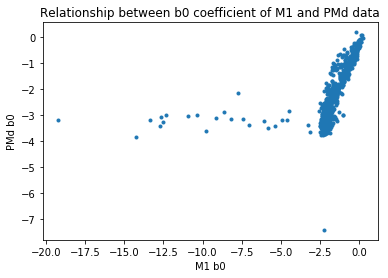

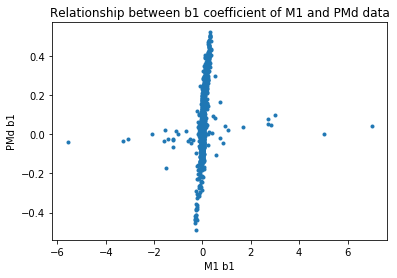

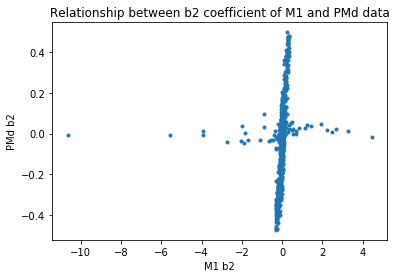

In [5]:
for i in range(n_reaches):
    M1_neural_data = reaches[i]["M1 neural data"]
    PMd_neural_data = reaches[i]["PMd neural data"]
    n_spikes_M1 = np.sum(M1_neural_data, axis=0)/67.0
    n_spikes_PMd = np.sum(PMd_neural_data, axis=0)/94.0
    trial_num = reaches[i]["trial number"]
    timestamps = reaches[i]["timestamps"]
    start_time = reaches[i]["start time"]
    end_time = reaches[i]["end time"]
    kinematics = reaches[i]["kinematics"]
    start_idx = 0
    end_idx = timestamps.size-1
    while timestamps[start_idx+1]<start_time:
        start_idx += 1
    while timestamps[end_idx]>end_time:
        end_idx -= 1
    n_spikes_M1 = n_spikes_M1[start_idx:end_idx]
    n_spikes_PMd = n_spikes_PMd[start_idx:end_idx]
    features = []
    n_features = 2
    for j in range(len(kinematics)):
        features.append([kinematics[j]["velocity"][0], kinematics[j]["velocity"][1]])
    features = np.array(features)
    features = features[start_idx:end_idx, : ]
    
    glm_M1 = GLM(distr='poisson', score_metric='pseudo_R2', reg_lambda=0.05, alpha=0.01)
    glm_M1.fit(features, n_spikes_M1)
    b0_M1.append(glm_M1.beta0_)
    b1_M1.append(glm_M1.beta_[0])
    b2_M1.append(glm_M1.beta_[1])
    
    glm_PMd = GLM(distr='poisson', score_metric='pseudo_R2', reg_lambda=0.05, alpha=0.01)
    glm_PMd.fit(features, n_spikes_PMd)
    b0_PMd.append(glm_PMd.beta0_)
    b1_PMd.append(glm_PMd.beta_[0])
    b2_PMd.append(glm_PMd.beta_[1])

plt.figure()
plt.plot(b0_M1, b0_PMd, '.')
plt.xlabel('M1 b0')
plt.ylabel('PMd b0')
plt.title("Relationship between b0 coefficient of M1 and PMd data")
plt.show()

plt.figure()
plt.plot(b1_M1, b1_PMd, '.')
plt.xlabel('M1 b1')
plt.ylabel('PMd b1')
plt.title("Relationship between b1 coefficient of M1 and PMd data")
plt.show()

plt.figure()
plt.plot(b2_M1, b2_PMd, '.')
plt.xlabel('M1 b2')
plt.ylabel('PMd b2')
plt.title("Relationship between b2 coefficient of M1 and PMd data")
plt.show()

## Smoothness of Tractory - Minimum Jerk Trajectory

In the next section, we wonder if the kinematic data over reaches will indicate that Monkey MT have learnt from previous experience. In the project, we use smoothness of trajectory (both position and velocity) as an indicator of proficiency.

We use the Minimum jerk trajectory to set up a baseline of a smooth trajectory. The minimum jerk trajectory is based on minimizing the sum of the squared jerk (time derivative of acceleration) along its trajectory. The details are out of scope of this project. Instead, we will use the following equations to generate predicted trajectory

\begin{aligned}
    x(t) &= x_i + (x_f - x_i)(10(\frac{t}{d})^3 - 10(\frac{t}{d})^4 + 6(\frac{t}{d})^5) \\
    \dot{x}(t) &= \frac{1}{d}(x_f - x_i)(30(\frac{t}{d})^2 - 60(\frac{t}{d})^4 + 3(\frac{t}{d})^5)
\end{aligned}
- $x(t)$ refers to the prediced position at time $t$ and $\dot{x}(t)$ refers to the velocity at time $t$. Note that $\dot{x}(t)$ is the derivative of $x(t)$.

In [8]:
def mjtg(current, setpoint, frequency, move_time):
    trajectory = []
    trajectory_derivative = []
    timefreq = round(move_time * frequency)

    for time in range(0, timefreq):
        trajectory.append(
            current + (setpoint - current) *
            (10.0 * (time/timefreq)**3
             - 15.0 * (time/timefreq)**4
             + 6.0 * (time/timefreq)**5))

        trajectory_derivative.append(
            frequency * (1.0/timefreq) * (setpoint - current) *
            (30.0 * (time/timefreq)**2.0
             - 60.0 * (time/timefreq)**3.0
             + 30.0 * (time/timefreq)**4.0))

    return trajectory, trajectory_derivative

In the following code, we are going to visualize the prediceted and actual trajectory of reach $9$. It can be seen from the graph that both position and velocity are smoothed using Minimum Jerk Trajectory.

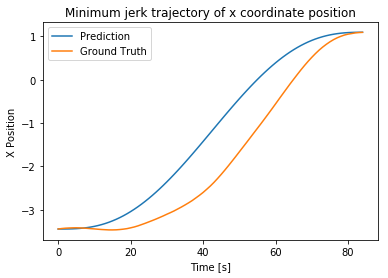

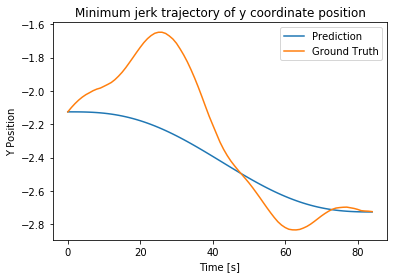

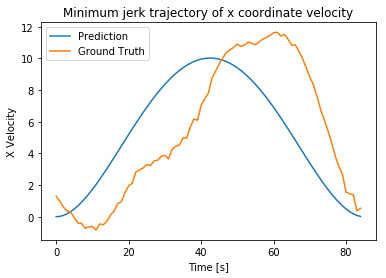

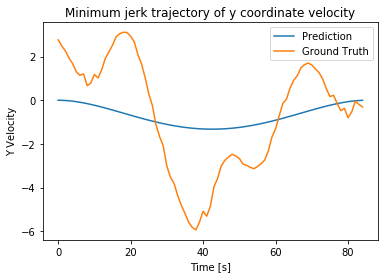

In [10]:
i = 9
timestamps = reaches[i]["timestamps"]
start_time = reaches[i]["start time"]
end_time = reaches[i]["end time"]
kinematics = reaches[i]["kinematics"]
start_idx = 0
end_idx = timestamps.size-1
while timestamps[start_idx+1]<start_time:
        start_idx += 1
while timestamps[end_idx]>end_time:
        end_idx -= 1
vel_x = []
pos_x = []
vel_y = []
pos_y = []
for j in range(len(kinematics)):
    vel_x.append(kinematics[j]["velocity"][0])
    pos_x.append(kinematics[j]["position"][0])
    vel_y.append(kinematics[j]["velocity"][1])
    pos_y.append(kinematics[j]["position"][1])
vel_x = vel_x[start_idx:end_idx]
pos_x = pos_x[start_idx:end_idx]
vel_y = vel_y[start_idx:end_idx]
pos_y = pos_y[start_idx:end_idx]
    
current_x = reaches[i]["kinematics"][start_idx]["position"][0]
setpoint_x = reaches[i]["kinematics"][end_idx]["position"][0]
time = round(float(timestamps[end_idx] - timestamps[start_idx])*100.0)/100.0
frequency = 100
traj_x, traj_vel_x = mjtg(current_x, setpoint_x, frequency, time)

current_y = reaches[i]["kinematics"][start_idx]["position"][1]
setpoint_y = reaches[i]["kinematics"][end_idx]["position"][1]
traj_y, traj_vel_y = mjtg(current_y, setpoint_y, frequency, time)

xaxis = np.arange(0, round(time*100))

plt.figure()
plt.plot(xaxis, traj_x)
plt.plot(xaxis, pos_x)
plt.title("Minimum jerk trajectory of x coordinate position")
plt.xlabel("Time [s]")
plt.ylabel("X Position")
plt.legend(['Prediction', 'Ground Truth'])
plt.show()

plt.figure()
plt.plot(xaxis, traj_y)
plt.plot(xaxis, pos_y)
plt.title("Minimum jerk trajectory of y coordinate position")
plt.xlabel("Time [s]")
plt.ylabel("Y Position")
plt.legend(['Prediction', 'Ground Truth'])
plt.show()

plt.figure()
plt.plot(xaxis, traj_vel_x)
plt.plot(xaxis, vel_x)
plt.title("Minimum jerk trajectory of x coordinate velocity")
plt.xlabel("Time [s]")
plt.ylabel("X Velocity")
plt.legend(['Prediction', 'Ground Truth'])
plt.show()

plt.figure()
plt.plot(xaxis, traj_vel_y)
plt.plot(xaxis, vel_y)
plt.title("Minimum jerk trajectory of y coordinate velocity")
plt.xlabel("Time [s]")
plt.ylabel("Y Velocity")
plt.legend(['Prediction', 'Ground Truth'])
plt.show()

## L2 distance of reaches

After calculating the baseline for each reach, we calculate the averaged l2 distance between the predicted trajectory (since the durations of reaches are different) 

The results, as indicated below, is not very positive. Over 496 reaches, the l2 distance is not changing significantly. We are not sure whether smoothness is not a good indicator or other reasons. 

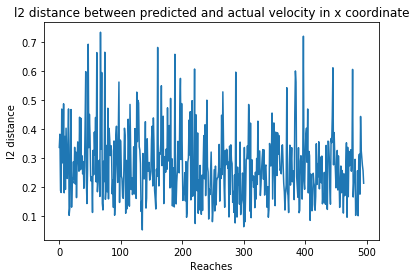

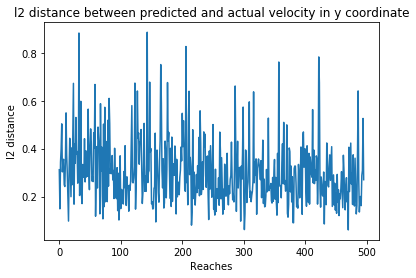

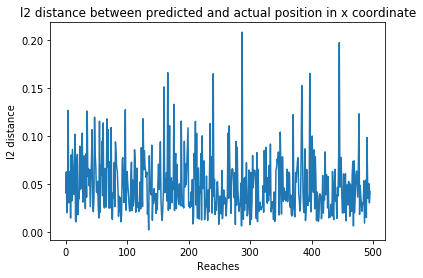

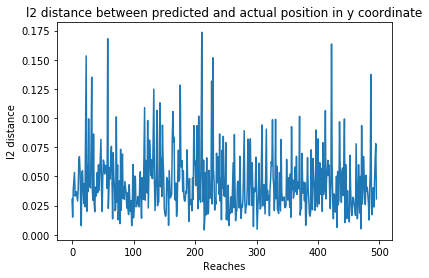

In [12]:
velx_l2 = []
posx_l2 = []
vely_l2 = []
posy_l2 = []
for i in range(n_reaches):
    M1_neural_data = reaches[i]["M1 neural data"]
    PMd_neural_data = reaches[i]["PMd neural data"]
    n_spikes_M1 = np.sum(M1_neural_data, axis=0)/67.0
    n_spikes_PMd = np.sum(PMd_neural_data, axis=0)/94.0
    trial_num = reaches[i]["trial number"]
    timestamps = reaches[i]["timestamps"]
    start_time = reaches[i]["start time"]
    end_time = reaches[i]["end time"]
    kinematics = reaches[i]["kinematics"]
    start_idx = 0
    end_idx = timestamps.size-1
    while timestamps[start_idx+1]<start_time:
        start_idx += 1
    while timestamps[end_idx]>end_time:
        end_idx -= 1
    n_spikes_M1 = n_spikes_M1[start_idx:end_idx]
    n_spikes_PMd = n_spikes_PMd[start_idx:end_idx]
    features = []
    n_features = 2
    vel_x = []
    pos_x = []
    vel_y = []
    pos_y = []
    for j in range(len(kinematics)):
        features.append([kinematics[j]["position"][0], kinematics[j]["position"][1]])
        vel_x.append(kinematics[j]["velocity"][0])
        pos_x.append(kinematics[j]["position"][0])
        vel_y.append(kinematics[j]["velocity"][1])
        pos_y.append(kinematics[j]["position"][1])
    features = np.array(features)
    features = features[start_idx:end_idx, : ]
    vel_x = vel_x[start_idx:end_idx]
    pos_x = pos_x[start_idx:end_idx]
    vel_y = vel_y[start_idx:end_idx]
    pos_y = pos_y[start_idx:end_idx]

    current_x = reaches[i]["kinematics"][start_idx]["position"][0]
    setpoint_x = reaches[i]["kinematics"][end_idx]["position"][0]
    time = round(float(timestamps[end_idx] - timestamps[start_idx])*100.0)/100.0
    frequency = 100
    traj_x, traj_vel_x = mjtg(current_x, setpoint_x, frequency, time)

    current_y = reaches[i]["kinematics"][start_idx]["position"][1]
    setpoint_y = reaches[i]["kinematics"][end_idx]["position"][1]
    traj_y, traj_vel_y = mjtg(current_y, setpoint_y, frequency, time)

    xaxis = np.arange(0, round(time*100))
    
    velx_l2.append(np.linalg.norm(np.array(traj_vel_x)-np.array(vel_x))/time/100.0)
    posx_l2.append(np.linalg.norm(np.array(traj_x)-np.array(pos_x))/time/100.0)
    vely_l2.append(np.linalg.norm(np.array(traj_vel_y) - np.array(vel_y))/time/100.0)
    posy_l2.append(np.linalg.norm(np.array(traj_y) - np.array(pos_y))/time/100.0)

reaches_range = np.arange(0, n_reaches)
plt.figure()
plt.plot(reaches_range, velx_l2)
plt.xlabel('Reaches')
plt.ylabel('l2 distance')
plt.title("l2 distance between predicted and actual velocity in x coordinate")
plt.show()

plt.figure()
plt.plot(reaches_range, vely_l2)
plt.xlabel('Reaches')
plt.ylabel('l2 distance')
plt.title("l2 distance between predicted and actual velocity in y coordinate")
plt.show()

plt.figure()
plt.plot(reaches_range, posx_l2)
plt.xlabel('Reaches')
plt.ylabel('l2 distance')
plt.title("l2 distance between predicted and actual position in x coordinate")
plt.show()

plt.figure()
plt.plot(reaches_range, posy_l2)
plt.xlabel('Reaches')
plt.ylabel('l2 distance')
plt.title("l2 distance between predicted and actual position in y coordinate")
plt.show()

## Discussion 
- Limitations: 
    - In this project, we focus on temporal difference  but ignore the spatial variety, since all the neurons are indexed and we are not able to tell the exact location of each neuron
    - It would be better if we can test on multiple datasets.

- Next Steps:
    - We could possibly use richer models, such as Linear-Nonlinear-Time-Warp-Poisson Model presented in the paper of pmd-1 dataset
    - Acceleration would also be a good independent variable, since it relates to muscle force. However, we are not able to get positive results from this dataset
    - Explore other reasonable indicators of learning rather than smoothness


## Acknowledgement
Lawlor, P.N., Perich, M.G., Miller, L.E. et al. Linear-nonlinear-time-warp-poisson models of neural activity. J Comput Neurosci 45, 173–191 (2018). https://doi.org/10.1007/s10827-018-0696-6

Flash T, and Hogan N (1985) The coordination of arm movements: an experimentally confirmed mathematical model. J Neurosci 5: 1688-1703 
